This is a PINN (Physics-Informed Neural Network) model, that computes the solution of a differential equation, using only the tensorflow library.

It makes use of jacobian and hessian methods for derivatives calculation,domain creation methods for function and initial condition intervals:
<br>

$$-y''= π^2*sin(πx), x∈[-1,1]$$

$$y(-1) = 0, y(1) = 0$$

<br>

It calculates the solution with a 7.016892777755857e-05 loss in 5000 epochs.

In [1]:
# Import tensorflow and numpy

import tensorflow as tf
import numpy as np

In [2]:
# Method for domain

def domain(minval, maxval, num_domain):
  domain_space = tf.random_uniform_initializer(minval, maxval)
  domain_points = tf.Variable(domain_space(shape=[num_domain, 1]), dtype=tf.float32)
  return domain_points

x = domain(-1, 1, 500)

In [3]:
# Method for jacobian derivatives

J = {}
def jacobian(tape, y, x, i = 0, j = 0):
  key = (y.ref(), x.ref())

  if y.shape[1] > 1:
    y = y[:, i : i + 1]

  if key not in J:
    y_index = {}
    y_index[i] = tape.gradient(y, x)
    J[key] = y_index

  if i not in J[key]:
    J[key][i] = tape.gradient(y, x)

  return J[key][i][:, j : j + 1]

In [4]:
# Method for hessian derivatives

H = {}
def hessian(tape, y, x, i = 0, j = 0, component = 0):

  key = (y.ref(), x.ref())

  if (key not in J) or (component not in J[key]):
    jacobian(tape, y, x, component, i)

  grad = J[key][component][:, i : i + 1]

  if key not in H:
    y_index = {}
    x_index = {}
    x_index[i] = tape.gradient(grad, x)
    y_index[component] = x_index
    H[key] = y_index

  if component not in H[key]:
    x_index = {}
    x_index[i] =  tape.gradient(grad, x)
    H[key][component] = x_index

  if i not in H[key][component]:
    H[key][component][i] =  tape.gradient(grad, x)

  return H[key][component][i][:, j : j + 1]

In [5]:
# Method for PDE

def pde(tape, x, y):
  dy_xx = hessian(tape, y, x, i = 0, j = 0)
  return dy_xx + np.pi ** 2 * tf.sin(np.pi * x)

In [6]:
# Method for the output of initial conditions

def ic_result(x):
  return 0

def ic_domain(input, num_domain):
  return tf.constant(input, shape=[num_domain,1])

x_ic_1 = ic_domain(-1, 1)
x_ic_2 = ic_domain(1, 1)

In [7]:
# Βuilding the model

n_inputs = 1
n_outputs = 1
activation = 'tanh'

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input((n_inputs,)))
model.add(tf.keras.layers.Dense(units=60, activation=activation))
model.add(tf.keras.layers.Dense(units=60, activation=activation))
model.add(tf.keras.layers.Dense(units=n_outputs))

In [8]:
epochs = 5000
learning_rate = 0.001

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

for i in range(epochs + 1):
  with tf.GradientTape() as tape_model:
    
    with tf.GradientTape(persistent=True) as tape_pde:
      y = model(x, training=True)
      domain_error = pde(tape_pde, x, y)
    
    domain_mse = tf.math.reduce_mean(tf.math.square(domain_error), axis=0)

    ic_error_1 = model(x_ic_1, training=True)[0][0] - ic_result(x_ic_1)
    ic_error_2 = model(x_ic_2, training=True)[0][0] - ic_result(x_ic_2)

    ic_mse_1 = tf.math.square(ic_error_1)
    ic_mse_2 = tf.math.square(ic_error_2)
    
    total_mse = domain_mse + ic_mse_1 + ic_mse_2

    if i % 1000 == 0:
      print('Epoch: {}\t MSE Loss = {}'.format(i, total_mse.numpy()[0]))

  model_update_gradients = tape_model.gradient(total_mse, model.trainable_variables)
  optimizer.apply_gradients(
    zip(model_update_gradients, model.trainable_variables)
  )

Epoch: 0	 MSE Loss = 47.28173828125
Epoch: 1000	 MSE Loss = 0.0004837367741856724
Epoch: 2000	 MSE Loss = 0.0001589710736880079
Epoch: 3000	 MSE Loss = 9.359304385725409e-05
Epoch: 4000	 MSE Loss = 0.0013203368289396167
Epoch: 5000	 MSE Loss = 7.016892777755857e-05


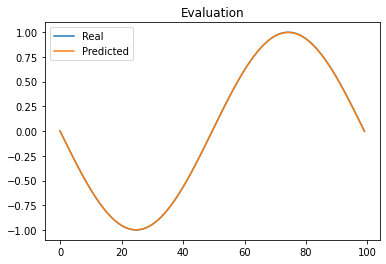

In [9]:
import matplotlib.pyplot as plt

x_test = np.linspace(-1, 1, 100)
y_true = tf.sin(np.pi*x_test)
y_pred = model(x_test)

plt.plot(y_true)
plt.plot(y_pred)
plt.title('Evaluation')
plt.legend(['Real', 'Predicted'])
plt.show()